# Text Classification

In [34]:
! pip install kaggle wordcloud

     |████████████████████████████████| 435 kB 1.3 MB/s            


In [2]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 93%|███████████████████████████████████▍  | 24.0M/25.7M [00:01<00:00, 27.9MB/s]
100%|██████████████████████████████████████| 25.7M/25.7M [00:01<00:00, 18.3MB/s]


In [3]:
# ! unzip data/imdb-dataset-of-50k-movie-reviews.zip

### Import Libs

In [64]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

### Options

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Data

In [6]:
df = pd.read_csv('./data/imdb-dataset-of-50k-movie-reviews.zip', compression='zip', encoding = 'utf-8')

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

### Preprocessing

In [16]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile("\'s")  # matches `'s` from text  
PATTERN_RN = re.compile("\\r\\n") #matches `\r` and `\n`
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace 

In [21]:
def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers.
        text (str): input text
    return (str): modified initial text
    """
    text = text.lower()  # lowercase text
    text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_RN, ' ', text)
    text = re.sub(PATTERN_PUNC, ' ', text)
    return text

In [22]:
def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    """
    Lemmatize, tokenize, crop and remove stop words.
    """
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence, language='english')]
    else:
        tokens = [w for w in word_tokenize(sentence, language='english')]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    return tokens   

In [23]:
def clean_sentences(df, column):
    """
    Remove irrelavant characters (in new column clean_sentence).
    Lemmatize, tokenize words into list of words (in new column tok_lem_sentence).
    """
    print('Cleaning sentences...')
    df['clean_sentence'] = df[column].apply(clean_text)
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True))
    return df

In [28]:
df_clean = clean_sentences(df, column='review')

Cleaning sentences...


In [29]:
df_clean.head()

,review,sentiment,clean_sentence,tok_lem_sentence
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewer, ha, mentioned,..."
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the...,"[a, wonderful, little, production, br, br, the..."
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,"[i, thought, this, wa, a, wonderful, way, to, ..."
3,Basically there's a family where a little boy ...,negative,basically there a family where a little boy ...,"[basically, there, a, family, where, a, little..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love in the time of money is ...,"[petter, mattei, love, in, the, time, of, mone..."


### Word cloud for positive review words

<function matplotlib.pyplot.show(close=None, block=None)>

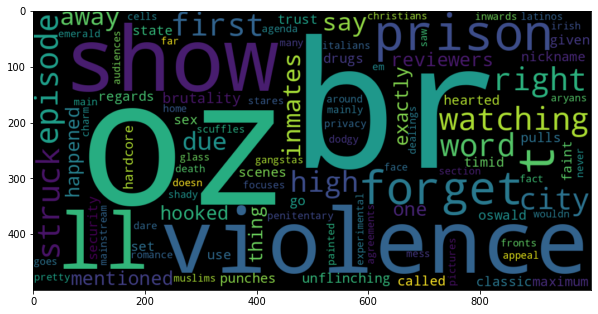

In [40]:
#word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text = df_clean[df_clean['sentiment']=='positive']['clean_sentence'].iloc[0]
wc = WordCloud(width=1000, height=500, max_words=100, min_font_size=5)
positive_words = wc.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

### Word cloud for negative review words

<function matplotlib.pyplot.show(close=None, block=None)>

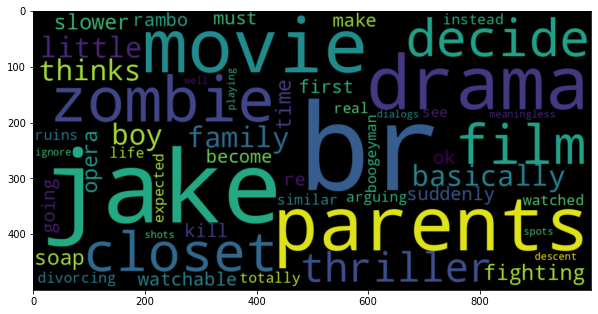

In [41]:
#word cloud for negative review words
plt.figure(figsize=(10,10))
positive_text = df_clean[df_clean['sentiment']=='negative']['clean_sentence'].iloc[0]
wc = WordCloud(width=1000, height=500, max_words=100, min_font_size=5)
positive_words = wc.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

### Embeddings

In [45]:
dim = 300 
wv_model = Word2Vec(sentences=df_clean['tok_lem_sentence'].values, vector_size=dim, workers=4, min_count=1)

In [46]:
wv_model.wv.most_similar('parent', topn=10)

[('mother', 0.7166745662689209),
 ('daughter', 0.6648603677749634),
 ('father', 0.6555734872817993),
 ('grandmother', 0.6538947820663452),
 ('grandparent', 0.6413975358009338),
 ('son', 0.6382991075515747),
 ('niece', 0.6331595182418823),
 ('mom', 0.6313422918319702),
 ('spouse', 0.6297757625579834),
 ('child', 0.6197348237037659)]

### Model

In [48]:
# Encoding the label column
df_clean['label'] = df_clean['sentiment'].map({'negative': 0, 'positive': 1})

In [49]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split (df_clean['tok_lem_sentence'], df_clean['label'] , test_size=0.2)

In [51]:
w2v_model = Word2Vec(X_train, vector_size=dim, window=5, min_count=2)

In [55]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train])
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [56]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

### Logistic Regression

In [61]:
log_reg = LogisticRegression(max_iter=1000)

In [62]:
log_reg_model = log_reg.fit(X_train_vect_avg, y_train.values.ravel())

In [63]:
# Use the trained model to make predictions on the test data
y_pred = log_reg_model.predict(X_test_vect_avg)

In [65]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [66]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Precision: 0.844 / Recall: 0.867 / Accuracy: 0.856
